In [24]:
import pandas as pd
import os 

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

In [25]:
database = pd.read_csv('./data/electric_train_cp949.csv', encoding='cp949', index_col=0)
database['electric_train.tm'] = pd.to_datetime(database['electric_train.tm'])

print(database.shape)

(7593355, 16)


In [26]:
elec_cols = ['electric_train.'+ a for a in ['tm', 'hh24', 'weekday', 'week_name', 'sum_qctr', 'n', 'sum_load', 'n_mean_load', 'elec']]

weat_cols = ['electric_train.'+ a for a in ['num', 'stn', 'nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_rn_60m', 'nph_ta_chi']]

reset_order_cols = elec_cols + weat_cols

df_new = database[reset_order_cols]
colunms = {}
for col in reset_order_cols:
    colunms[col] = col.split('.')[1]

df_new = df_new.rename(columns=colunms)

df_new['year'] = df_new['tm'].dt.year
df_new['month'] = df_new['tm'].dt.month
df_new['day'] = df_new['tm'].dt.day
df_new = df_new.sort_values(by='tm')

# 시즌을 결정하는 함수
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# 'season' 컬럼 추가
df_new['season'] = df_new['tm'].dt.month.apply(get_season)

df_new.head()

,tm,hh24,weekday,week_name,sum_qctr,n,sum_load,n_mean_load,elec,num,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,year,month,day,season
2647991,2020-01-01 01:00:00,1,2,0,63850,39,9732.96,250.490543,99.63,13615,140,-8.5,74.5,0.9,0.0,-5.8,2020,1,1,Winter
5208382,2020-01-01 01:00:00,1,2,0,14750,20,2401.12,116.010234,103.49,18235,565,-8.8,25.6,1.9,0.0,-4.6,2020,1,1,Winter
5182078,2020-01-01 01:00:00,1,2,0,71630,32,12139.16,363.252769,104.43,18234,565,-8.8,25.6,1.9,0.0,-4.6,2020,1,1,Winter
5155774,2020-01-01 01:00:00,1,2,0,45840,28,6723.84,225.924357,106.29,18233,512,-6.3,31.3,2.5,0.0,-7.8,2020,1,1,Winter
1280137,2020-01-01 01:00:00,1,2,0,76450,44,12949.24,287.250770,102.45,11272,941,2.4,68.0,1.2,0.0,-5.3,2020,1,1,Winter


In [27]:
cols_for_test = [
        'tm', 'year', 'season', 'month','day', 'weekday', 'hh24','week_name', 
        'num',
        'stn', 'nph_ta','nph_hm', 'nph_ws_10m',
       'nph_rn_60m', 'nph_ta_chi', 'elec']

df_train = df_new[cols_for_test]

df_train.head()

,tm,year,season,month,day,weekday,hh24,week_name,num,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,elec
2647991,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,13615,140,-8.5,74.5,0.9,0.0,-5.8,99.63
5208382,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,18235,565,-8.8,25.6,1.9,0.0,-4.6,103.49
5182078,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,18234,565,-8.8,25.6,1.9,0.0,-4.6,104.43
5155774,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,18233,512,-6.3,31.3,2.5,0.0,-7.8,106.29
1280137,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,11272,941,2.4,68.0,1.2,0.0,-5.3,102.45


### 이상치 처리

In [28]:
# 온도별 elec의 이상치 처리 
for idx in list(df_train.loc[df_train['elec'] < 0, 'nph_ta'].index):
    area_num = df_train.loc[idx]['num']
    season = df_train.loc[idx]['season']
    year = df_train.loc[idx]['year']
    temp = df_train.loc[idx]['nph_ta']
    df_train.loc[idx, 'elec'] = \
        df_train.loc[(df_train.loc[idx]['num'] == area_num) & (df_train.loc[idx]['year'] == year) & (df_train.loc[idx]['season'] == season) & (df_train['nph_ta'] == temp), :]['elec'].mean()
        # 해당 지역의 해당 연도의 해당 시즌의 해당 온도와 같은 날의 elec의 평균

In [29]:
# 풍속이 음수인 값을 갖는 이상치 처리

ano_list = list(df_train.loc[df_train['nph_ws_10m'] < 0, 'nph_ws_10m'].index)
for idx in ano_list:
    pre_idx = idx - 1
    nex_idx = idx + 1

    previous_value = df_train.loc[pre_idx, 'nph_ws_10m']
    next_value = df_train.loc[nex_idx, 'nph_ws_10m']
    mean_val = (previous_value + next_value) / 2
    df_train.loc[idx, 'nph_ws_10m'] = mean_val

In [30]:
print(len(df_train['stn'].unique()))
print(df_train['stn'].unique()[:10])

185
[140 565 512 941 114 940 459 937 364 445]


In [31]:
df_stn_140 = df_train[df_train['stn']==140]

In [32]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = df_stn_140.groupby(['num','weekday'])['elec'].median().reset_index().pivot(index='num',columns='weekday',values='elec').reset_index()
by_hour = df_stn_140.groupby(['num','hh24'])['elec'].median().reset_index().pivot(index='num',columns='hh24',values='elec').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hh24:'+str(i) for i in range(24)]
df.columns = columns

df.head()

,num,day0,day1,day2,day3,day4,day5,day6,hh24:0,hh24:1,...,hh24:14,hh24:15,hh24:16,hh24:17,hh24:18,hh24:19,hh24:20,hh24:21,hh24:22,hh24:23
0,13614,94.625,93.900,94.29,94.080,94.255,97.875,100.34,93.255,83.135,...,88.115,89.07,95.005,109.985,122.075,126.015,125.51,123.170,115.905,105.235
1,13615,94.125,93.095,93.38,93.235,93.335,97.655,99.86,91.530,79.790,...,87.760,87.87,94.505,111.550,126.385,129.505,129.07,126.485,117.775,105.135


In [33]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

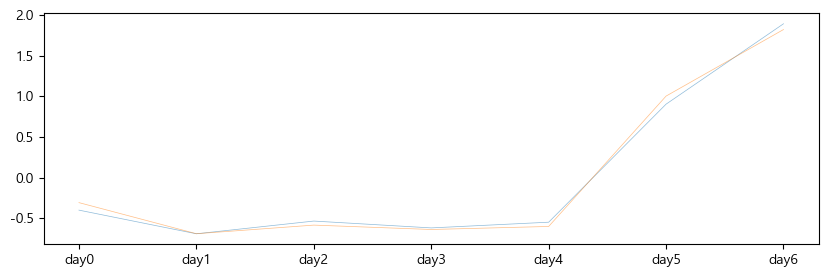

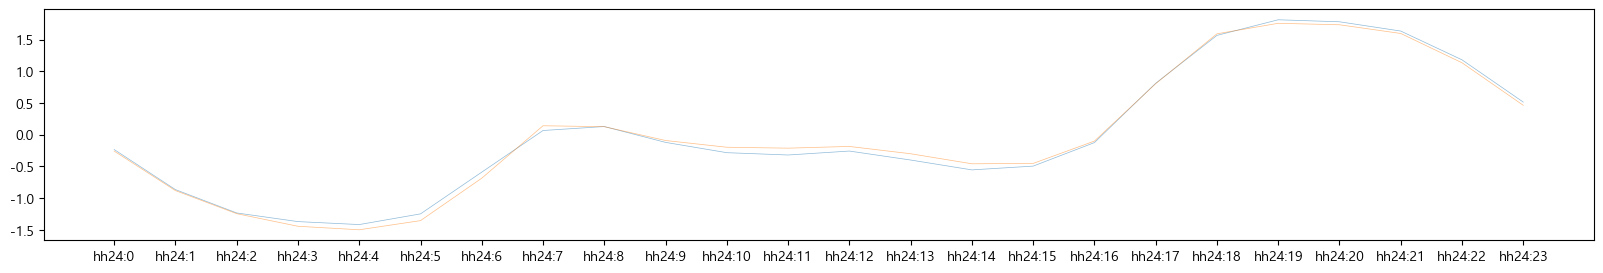

In [34]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

In [35]:
# 먼저 2020년 기록이 있는 데이터와 없는 데이터끼리 나눠보자 
spots_num = sorted(df_train['num'].unique().tolist())
df_1 = df_train[df_train['num']==spots_num[1]]

print(df_1['tm'].min(), df_1['tm'].max())

no_2020 = []
yes_2020 = []
for i in range(len(spots_num)):
    a = str(df_train[df_train['num']==spots_num[i]]['tm'].min())
    b = str(df_1['tm'].min())

    if a != b:
        no_2020.append(spots_num[i])
    else:
        yes_2020.append(spots_num[i])
        
print(len(no_2020))  # 2020년도 데이터가 없는 격자 지역 개수 23개
print(len(yes_2020)) # 2020년도 데이터가 있는 격자 지역 개수 300개

2020-01-01 01:00:00 2023-01-01 00:00:00
23
300


In [37]:
df1 = df_train[df_train['num'].isin(yes_2020)]
df2 = df_train[df_train['num'].isin(no_2020)]

In [38]:
print(df2['num'].unique())

print(len(df2['num'].unique()))

print('---'*10)

print(df2['stn'].unique())

print(len(df2['stn'].unique()))

[16900 16913 18828 14378 14258 15849 13648  4821  8994 10224 10975 12618
 12467 12322 13202 12619 11271 11562 11376 11119  9609 10976 13360]
23
------------------------------
[495 127 511 605 138 177 845 884 261 313 942 152 900 901 827 941 899 252
 908 168 283]
21


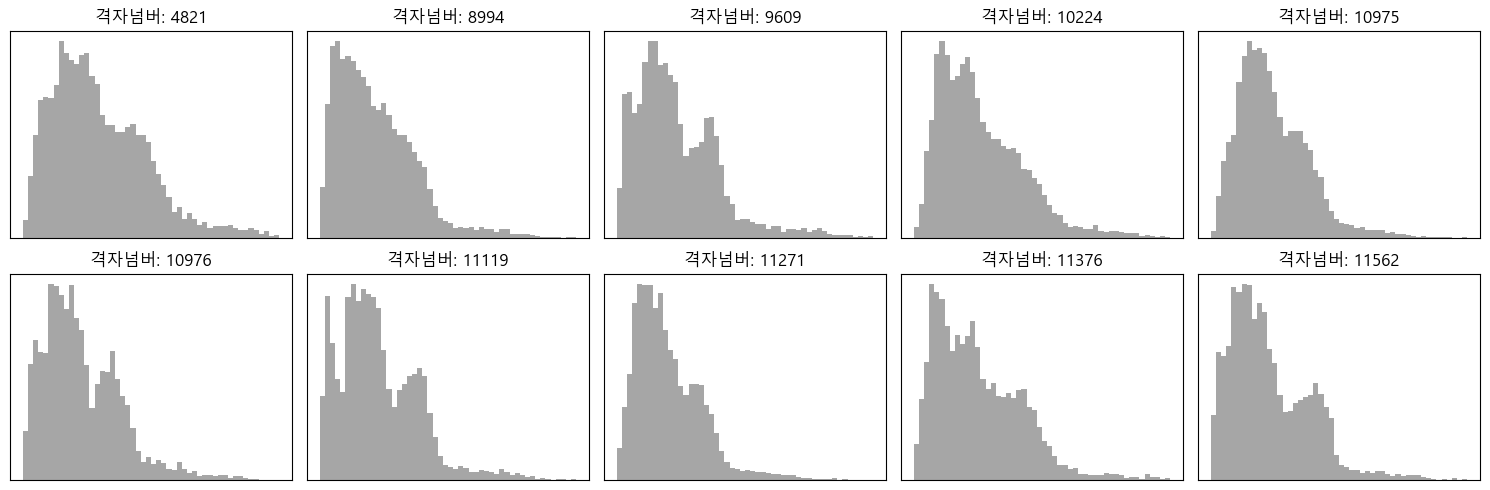

In [39]:
fig = plt.figure(figsize = (15, 5))
for idx, num in enumerate(no_2020[:10]):
    ax = plt.subplot(2, 5, 1+idx)
    energy = df2.loc[df2['num'] == no_2020[idx], 'elec'].values
    mean = energy.mean().round(3)           # 평균
    std = energy.std().round(3)             # 편차
    skew = (3*(mean - np.median(energy))/energy.std()).round(3) # 왜도

    # 왜도에 따라 
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
        
    plt.title(f'격자넘버: {no_2020[idx]}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    
plt.tight_layout()
plt.show()

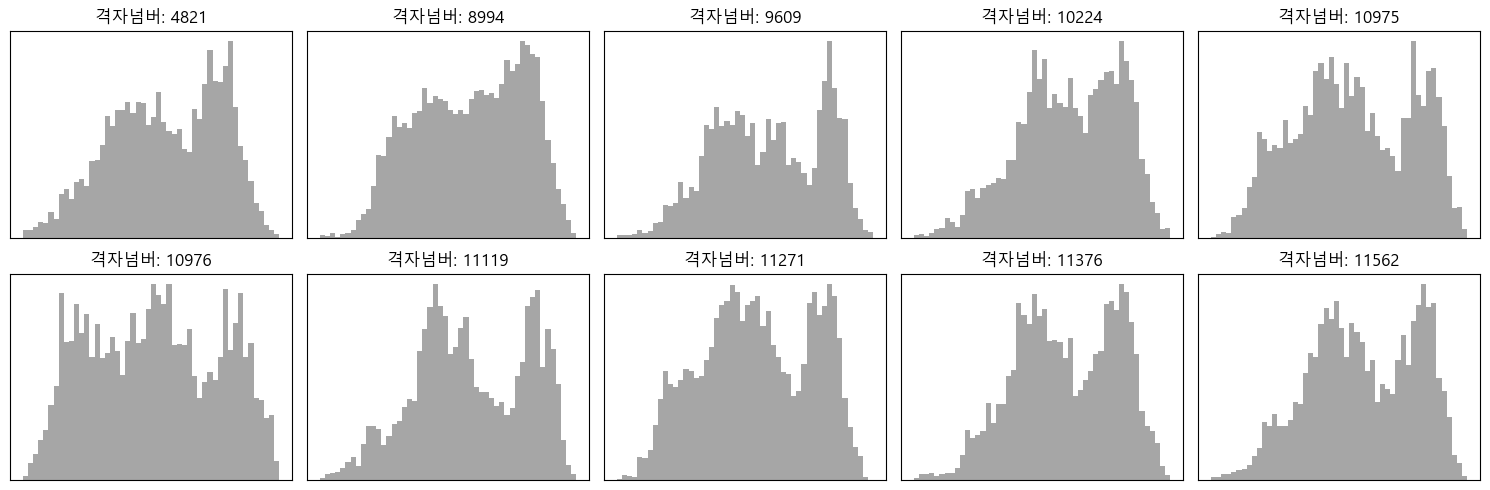

In [41]:
# 온도
fig = plt.figure(figsize = (15, 5))
for idx, num in enumerate(no_2020[:10]):
    ax = plt.subplot(2, 5, 1+idx)
    energy = df2.loc[df2['num'] == no_2020[idx], 'nph_ta'].values

    plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
        
    plt.title(f'격자넘버: {no_2020[idx]}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    
plt.tight_layout()
plt.show()



In [42]:
df_train['stn'].unique()[0]

140

In [69]:
stn_nums = []
most = 0
for stn in df_train['stn'].unique():
    
    nums_num = len(df_train[df_train['stn']==stn]['num'].unique())
    stn_nums.append([stn,nums_num])
    

stn_nums.sort(key=lambda x:x[1],reverse=True)

print(stn_nums)

[[846, 6], [541, 5], [133, 5], [565, 4], [937, 4], [899, 4], [572, 4], [152, 4], [617, 4], [493, 4], [550, 4], [119, 4], [511, 4], [146, 4], [138, 4], [827, 4], [279, 4], [941, 3], [114, 3], [940, 3], [445, 3], [371, 3], [255, 3], [253, 3], [942, 3], [783, 3], [546, 3], [908, 3], [162, 3], [450, 3], [428, 3], [532, 3], [168, 3], [788, 3], [404, 3], [636, 3], [143, 3], [140, 2], [512, 2], [434, 2], [904, 2], [590, 2], [376, 2], [649, 2], [112, 2], [939, 2], [551, 2], [127, 2], [545, 2], [257, 2], [673, 2], [543, 2], [313, 2], [589, 2], [427, 2], [710, 2], [506, 2], [101, 2], [184, 2], [353, 2], [165, 2], [774, 2], [599, 2], [433, 2], [156, 2], [192, 2], [950, 2], [822, 2], [860, 2], [693, 2], [824, 2], [642, 2], [496, 2], [327, 2], [702, 2], [864, 2], [131, 2], [129, 2], [840, 2], [845, 2], [459, 1], [364, 1], [377, 1], [548, 1], [533, 1], [430, 1], [438, 1], [938, 1], [509, 1], [492, 1], [974, 1], [247, 1], [471, 1], [288, 1], [245, 1], [516, 1], [898, 1], [358, 1], [432, 1], [472, 1],

In [49]:
df_stn_846 = df_train[df_train['stn']==846]

In [50]:
df_stn_846['num'].unique()

array([13349, 13348, 13498, 13199, 13200, 13497], dtype=int64)

In [52]:
df_stn_846['num'].unique()[0]

13349

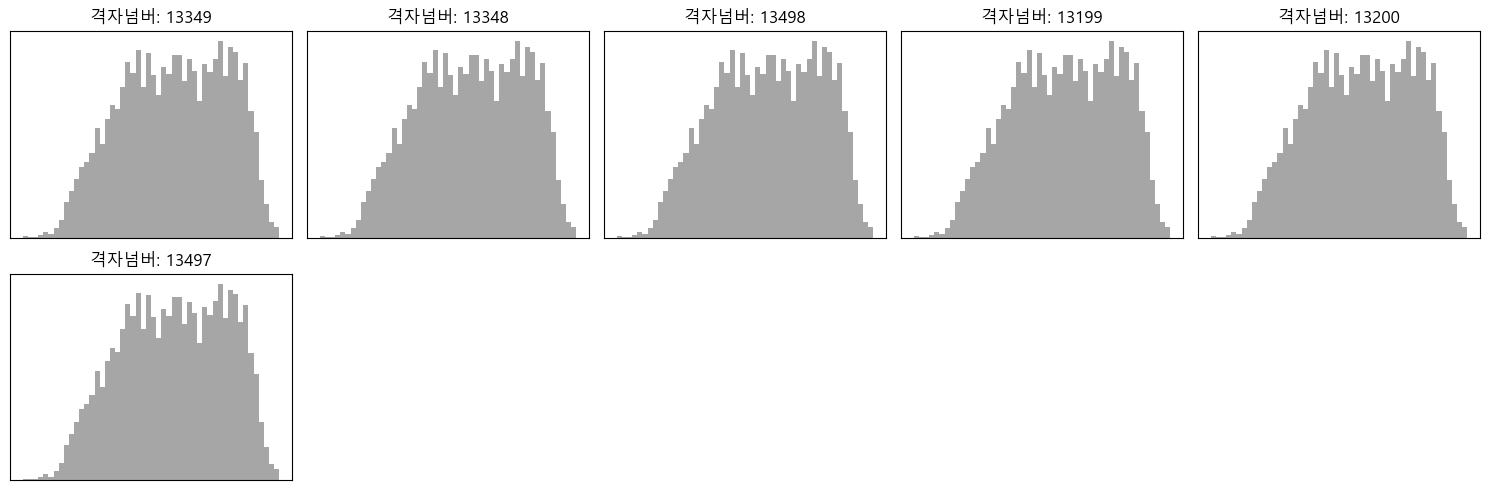

In [53]:
fig = plt.figure(figsize = (15, 5))
for idx, num in enumerate(df_stn_846['num'].unique()):
    ax = plt.subplot(2, 5, 1+idx)
    energy = df_stn_846['nph_ta'].values

    plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    
    num = df_stn_846['num'].unique()[idx]
    plt.title(f'격자넘버: {num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    
plt.tight_layout()
plt.show()

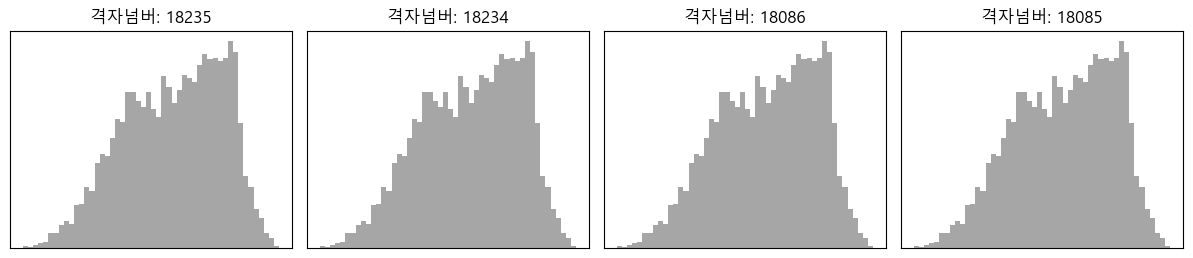

In [54]:
aws_num = df_train['stn'].unique()[1]
df_temp = df_train[df_train['stn']==aws_num]

fig = plt.figure(figsize = (15, 5))
for idx, num in enumerate(df_temp['num'].unique()):
    ax = plt.subplot(2, 5, 1+idx)
    energy = df_temp['nph_ta'].values

    plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    
    num = df_temp['num'].unique()[idx]
    plt.title(f'격자넘버: {num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    
plt.tight_layout()
plt.show()

In [55]:
df_temp.head()

,tm,year,season,month,day,weekday,hh24,week_name,num,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,elec
5208382,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,18235,565,-8.8,25.6,1.9,0.0,-4.6,103.49
5182078,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,18234,565,-8.8,25.6,1.9,0.0,-4.6,104.43
4945342,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,18086,565,-8.8,25.6,1.9,0.0,-4.6,103.66
4919038,2020-01-01 01:00:00,2020,Winter,1,1,2,1,0,18085,565,-8.8,25.6,1.9,0.0,-4.6,103.71
4945343,2020-01-01 02:00:00,2020,Winter,1,1,2,2,0,18086,565,-8.2,25.6,2.0,0.0,-4.7,98.91


In [56]:
df_temp['num'].unique()

array([18235, 18234, 18086, 18085], dtype=int64)

In [65]:
check_cols = ['stn', 'nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_rn_60m', 'nph_ta_chi']

df_temp[(df_temp['num']==18235) & (df_temp.tm=='2020-01-01 01:00:00')][check_cols].iloc[:2]

,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi
5208382,565,-8.8,25.6,1.9,0.0,-4.6


In [66]:
df_temp[(df_temp['num']==18234) & (df_temp.tm=='2020-01-01 01:00:00')][check_cols].iloc[:2]

,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi
5182078,565,-8.8,25.6,1.9,0.0,-4.6
